In [ ]:
# import library

import tensorfl ow as tf
from tensorflow.keras import layers, models, losses, metrics
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from sklearn.model_selection import train_test_split
import os


In [2]:
image_dir = "D:/Carol/projek ai/dataset/AMAZON/AMAZON/Test/image"
mask_dir = "D:/Carol/projek ai/dataset/AMAZON/AMAZON/Test/mask"

In [3]:
# load n preprocess data
def convert_to_uint8(image):
    # normalize the image to 0-255
    image = (image / image.max()) * 255.0
    return image.astype(np.uint8)


def load_data(image_dir, mask_dir):
    images = []
    masks = []

    image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(".tif")])
    mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir) if file.endswith(".tif")])

    for img_file, mask_file in zip(image_files, mask_files):
        images.append(imread(img_file))
        masks.append(imread(mask_file))
    
    # turn into numpy array
    images = np.array(images)
    masks = np.array(masks)

    # normalize image
    images = images.astype(np.float32) / 255.0
    masks = masks.astype(np.float32) / 255.0
    masks = masks / masks.max()  
    
    return images, masks


# image n mask path
image_dir = "D:/Carol/projek ai/dataset/AMAZON/AMAZON/Training/image"
mask_dir = "D:/Carol/projek ai/dataset/AMAZON/AMAZON/Training/label"
images, masks = load_data(image_dir, mask_dir)

# split data
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [4]:
# U-Net

def unet_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Decoder
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u1)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u2)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u3)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c7)

    return models.Model(inputs, outputs)

model = unet_model(input_shape=(images.shape[1], images.shape[2], images.shape[3]))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,921 (29.37 MB)

 Trainable params: 7,697,921 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# loss and metrics

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# F1
def f1_score(y_true, y_pred):
    y_true = tf.expand_dims(y_true, -1)
    y_pred = tf.round(y_pred)

    tp = tf.reduce_sum(y_true * y_pred)  # True positives
    fp = tf.reduce_sum((1 - y_true) * y_pred)  # False positives
    fn = tf.reduce_sum(y_true * (1 - y_pred))  # False negatives
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())


# compile model
model.compile(
    optimizer="adam", # adam optimizer
    loss="binary_crossentropy",
    metrics=[dice_coefficient, f1_score, metrics.MeanIoU(num_classes=2), "accuracy"]
)


In [ ]:
# print(f"x_train shape: {x_train.shape}")  # Should be [batch_size, heig ht, width, channels]
# print(f"y_train shape: {y_train.shape}")  # Should match predictions: [batch_size, height, width, 1]


x_train shape: (399, 512, 512, 4)
y_train shape: (399, 512, 512)


In [8]:
# training
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=6,
    batch_size=6,
    verbose=1
)


Epoch 1/6
67/67 ━━━━━━━━━━━━━━━━━━━━ 5036s 75s/step - accuracy: 0.7853 - dice_coefficient: 0.6950 - f1_score: 0.7149 - loss: 0.4684 - mean_io_u: 0.2512 - val_accuracy: 0.9206 - val_dice_coefficient: 0.8571 - val_f1_score: 0.9202 - val_loss: 0.2124 - val_mean_io_u: 0.2411
Epoch 2/6
67/67 ━━━━━━━━━━━━━━━━━━━━ 4919s 73s/step - accuracy: 0.8866 - dice_coefficient: 0.8343 - f1_score: 0.8904 - loss: 0.2770 - mean_io_u: 0.2338 - val_accuracy: 0.9301 - val_dice_coefficient: 0.8755 - val_f1_score: 0.9300 - val_loss: 0.1888 - val_mean_io_u: 0.2411
Epoch 3/6
67/67 ━━━━━━━━━━━━━━━━━━━━ 4899s 73s/step - accuracy: 0.9195 - dice_coefficient: 0.8650 - f1_score: 0.9177 - loss: 0.2117 - mean_io_u: 0.2432 - val_accuracy: 0.8800 - val_dice_coefficient: 0.8017 - val_f1_score: 0.8673 - val_loss: 0.2603 - val_mean_io_u: 0.2411
Epoch 4/6
67/67 ━━━━━━━━━━━━━━━━━━━━ 4917s 73s/step - accuracy: 0.9058 - dice_coefficient: 0.8687 - f1_score: 0.9069 - loss: 0.2152 - mean_io_u: 0.2263 - val_accuracy: 0.9500 - val_dic

4/4 ━━━━━━━━━━━━━━━━━━━━ 329s 78s/step - accuracy: 0.9591 - dice_coefficient: 0.9183 - f1_score: 0.9609 - loss: 0.1158 - mean_io_u: 0.2453
Validation Results: [0.11241555213928223, 0.921753466129303, 0.9658336043357849, 0.24114565551280975, 0.9612650871276855]
4/4 ━━━━━━━━━━━━━━━━━━━━ 346s 75s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039215688..22.22353].


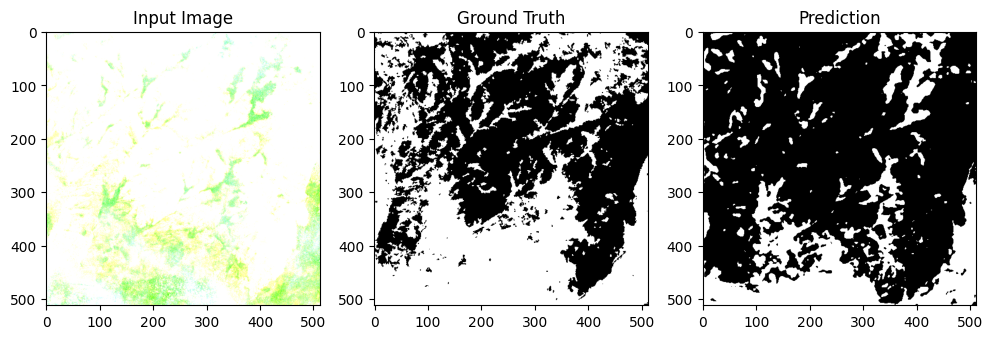

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15294118..20.97255].


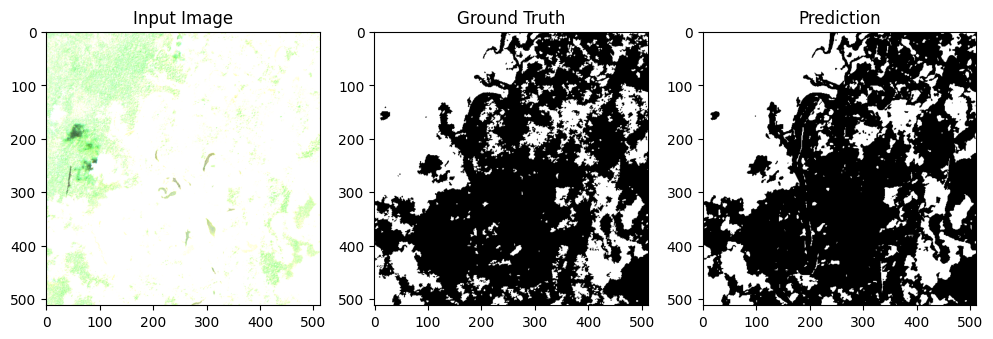

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21176471..23.886274].


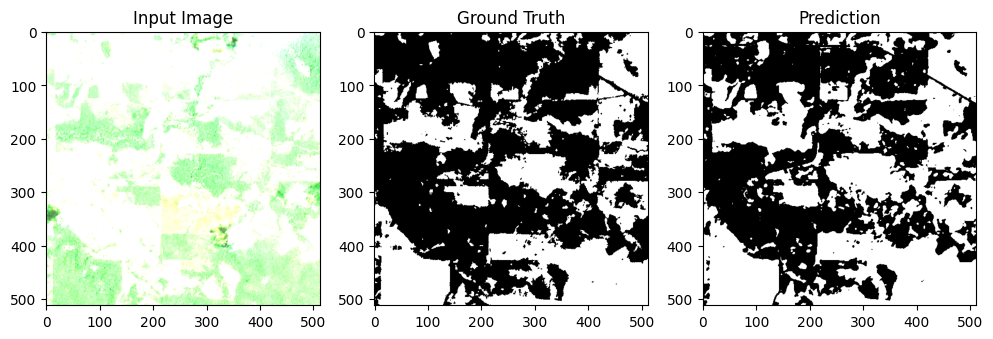

In [9]:
# evaluate and visualize
results = model.evaluate(x_val, y_val, verbose=1)
print("Validation Results:", results)


def visualize_predictions(images, masks, predictions, num=3):
    for i in range(num):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[i].squeeze(), cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[i].squeeze(), cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze(), cmap="gray")

        plt.show()


predictions = model.predict(x_val)
predictions = (predictions > 0.5).astype(np.float32)
visualize_predictions(x_val, y_val, predictions)


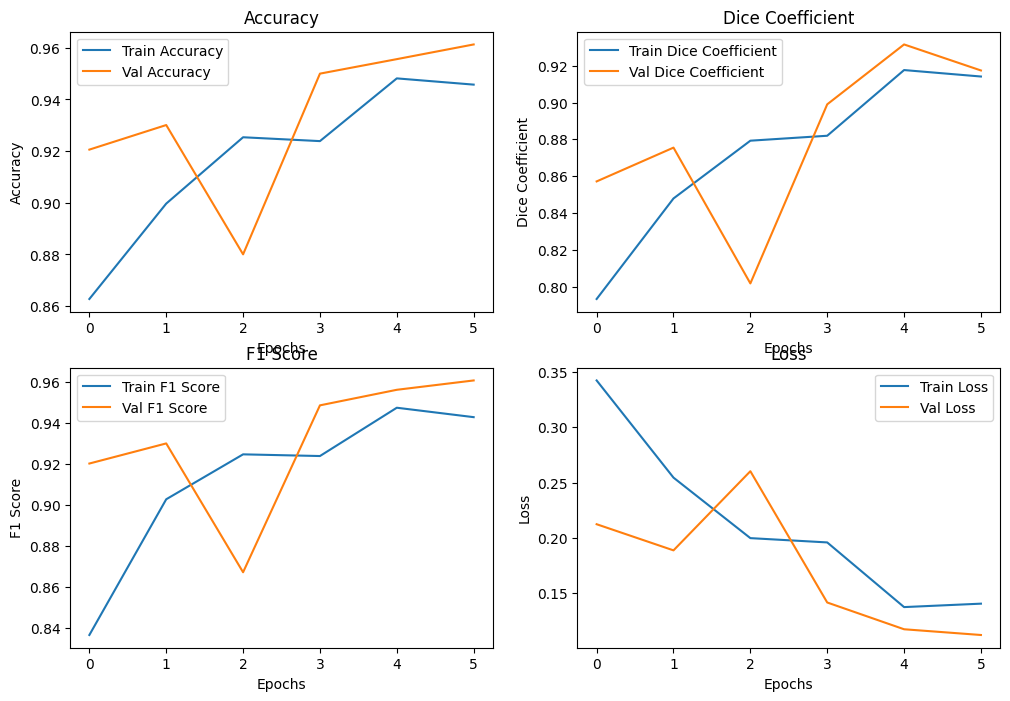

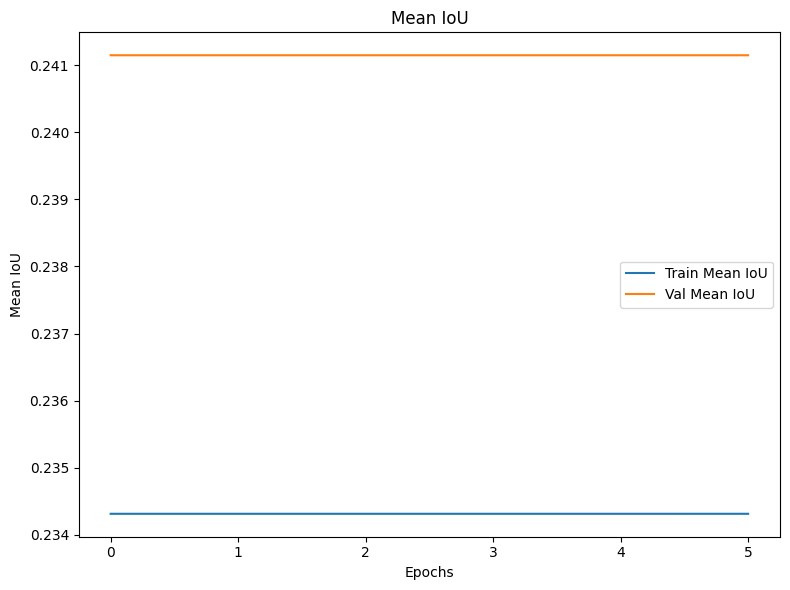

In [10]:
# plotting metrics

def plot_metrics(history):
    # Accuracy
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Dice Coefficient
    plt.subplot(2, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice Coefficient')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Val F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Mean IoU
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['mean_io_u'], label='Train Mean IoU')
    plt.plot(history.history['val_mean_io_u'], label='Val Mean IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(history)


In [ ]:
# save model
model.save("D:/Carol/projek ai/defores4.h5")
model.save_weights('segmentation_model_weights4.weights.h5')


In [16]:
# testing
new_image = imread("D:/Carol/projek ai/dataset/AMAZON/AMAZON/Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04.tif")

# preprocess
new_image = np.expand_dims(new_image, axis=-1)
new_image = new_image.astype(np.float32) / 255.0


new_image = np.expand_dims(new_image, axis=0)


In [17]:
from tensorflow.keras.models import load_model

model = load_model('defores4.h5', custom_objects={'f1_score': f1_score, 'dice_coefficient': dice_coefficient})


1/1 ━━━━━━━━━━━━━━━━━━━━ 189s 189s/step


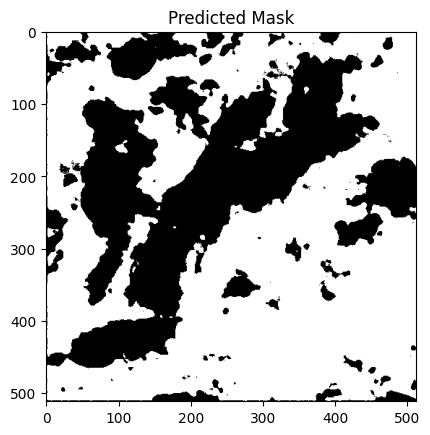

In [18]:
predictions = model.predict(new_image)

predictions = (predictions > 0.5).astype(np.float32)

plt.imshow(predictions.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.show()
